In [1]:
# Parameters
merged_raw_data = "MergedHerb.h5ad"
integrated_data = "IntegratedHerb.h5ad"



Author: Erno Hänninen

Created: 2023-22-01

Title: AnnotateHerbData.ipynb

Description:
 - Filters and annotates cell types to the raw timepoint data from Herb paper
 
Procedure:
 - ...

List of non-standard modules:
 - scanpy


In [2]:
import scanpy as sc

## Load and explore the integrated Herb data

The integrated Herb data is produced in this script: https://github.com/brianherb/HumanHypothalamusDev/blob/f87a2788cef62b55f6c66ba343634673ba30042a/Fig1_HumanEmbryonic.R 

In [3]:
#Read the integrated reference data (Fig1 from the paper)
adata_ref = sc.read_h5ad(integrated_data)

In [4]:
adata_ref

AnnData object with n_obs × n_vars = 40927 × 33694
    obs: 'nCount_RNA', 'nFeature_RNA', 'sample', 'percent.mt', 'nCount_SCT', 'nFeature_SCT', 'Timepoint', 'CurrentMeta', 'UMAP_1', 'UMAP_2', 'UMAP_3'
    var: '_index', 'features'
    obsm: 'X_umap'

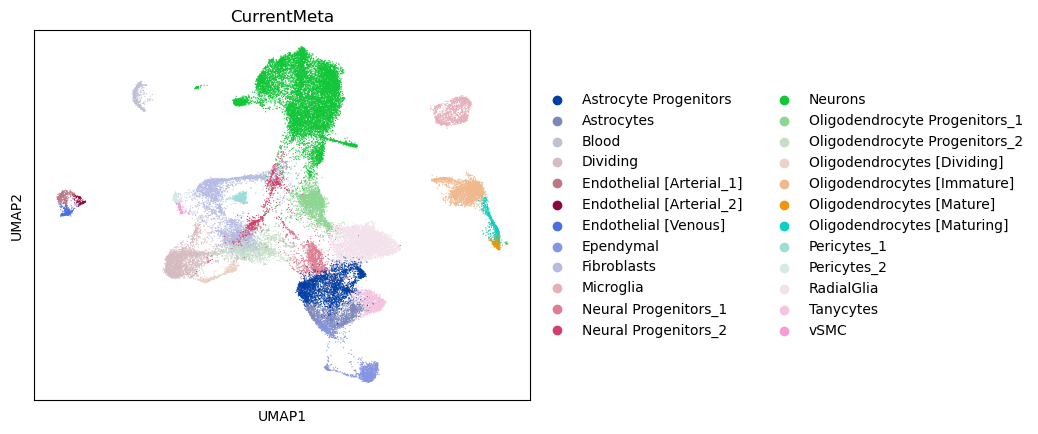

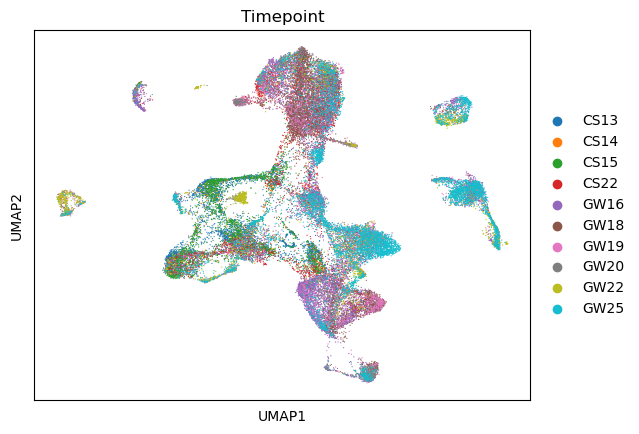

In [5]:
# Plot the celltypes and timpoint
sc.pl.umap(adata_ref, color="CurrentMeta")
sc.pl.umap(adata_ref, color="Timepoint" )

In [6]:
#Change to raw counts
adata_ref_raw = adata_ref.raw.to_adata()
#Copy the var names to the adata_ref_raw
adata_ref_raw.var_names = adata_ref.var_names

/home/bns631/.conda/envs/PYenv/lib/python3.10/site-packages/anndata/_core/raw.py:139: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  return anndata.AnnData(


## Filter, annotate and process the merged raw timepoint data

In [7]:
#Read the merged raw data to adata object
adata_batches = sc.read_h5ad(merged_raw_data)

In [8]:
# Reformat the object to aviod errors when writing the annotated data to file
del(adata_batches.var['_index'])
adata_batches.__dict__['_raw'].__dict__['_var'] = adata_batches.__dict__['_raw'].__dict__['_var'].rename(columns={'_index': 'features'})

In [9]:
#Print the number of the cells in the raw and integrated datasets
print(len(adata_batches.obs_names))
print(len(adata_ref_raw.obs_names))

59736
40927


In [10]:
#Raw data processing
#Filter away cells from the raw data that doesn't occur in the integrated datasets
#This way the dataset is "pre-processed" like it was done in the Herb paper
shared_cells = adata_ref_raw.obs_names.intersection(adata_batches.obs_names) #Takes the intersection of cells

adata_batches = adata_batches[shared_cells,:].copy() #Do the actual filtering

In [11]:
#Double check for identical obs.index (same cells in bot datasets)
adata_ref_raw.obs.index.identical(adata_batches.obs.index)

True

In [12]:
#Check that the dimensions are equal
print(adata_batches.shape)
print(adata_ref_raw.shape)

(40927, 33694)
(40927, 33694)


In [13]:
#Now when the obs.index between the two dataset is identical, move the CurrentMeta column to the raw adata_batches object
adata_batches.obs["Cell_types"] = adata_ref_raw.obs["CurrentMeta"]


In [14]:
adata_batches

AnnData object with n_obs × n_vars = 40927 × 33694
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'percent.mt', 'Cell_types'
    var: 'features'

In [15]:
#Store the raw counts
adata_batches.layers["counts"] = adata_batches.X.copy()
#Normalize and scale the data
sc.pp.normalize_total(adata_batches, target_sum=1e4)
sc.pp.log1p(adata_batches)

In [16]:
adata_batches.uns["log1p"]

{'base': None}

In [17]:
#Check that the counts in layers["counts"] are non-normalized
adata_batches.layers["counts"].todense()[185:190,185:190]

matrix([[0., 0., 0., 7., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0.],
        [0., 0., 0., 3., 3.]])

In [18]:
#Print the countes in adata.X
adata_batches.X.todense()[185:190,185:190]

matrix([[0.        , 0.        , 0.        , 2.08066751, 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.62356987, 0.        ],
        [0.        , 0.        , 0.        , 1.06735167, 0.        ],
        [0.        , 0.        , 0.        , 1.33467695, 1.33467695]])

In [19]:
#Write the processed data to file
adata_batches.write("Processed_herb_adata.h5ad")

#When reading the data run adata_batches.uns["log1p"] = {"base":None}

In [20]:
#Identify hvg
sc.pp.highly_variable_genes(adata_batches)

#Scale data
sc.pp.scale(adata_batches)

#Process the data
sc.tl.pca(adata_batches)
sc.pp.neighbors(adata_batches)
sc.tl.umap(adata_batches)

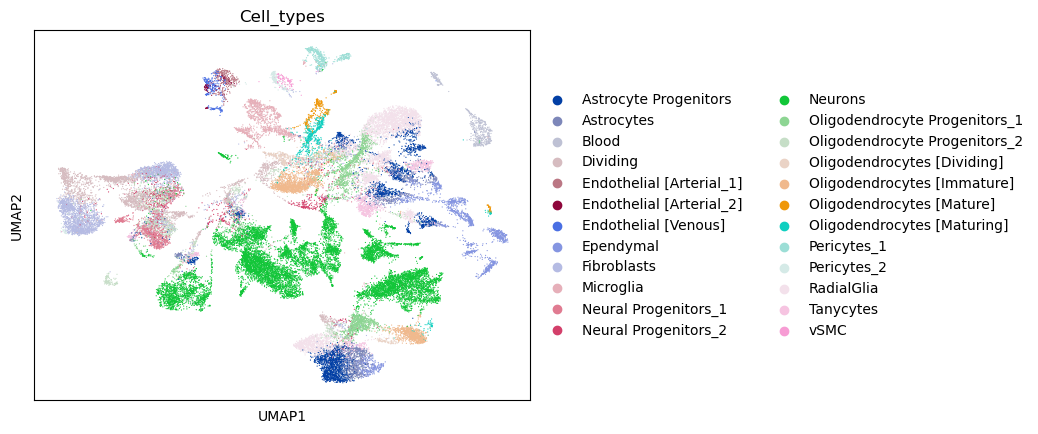

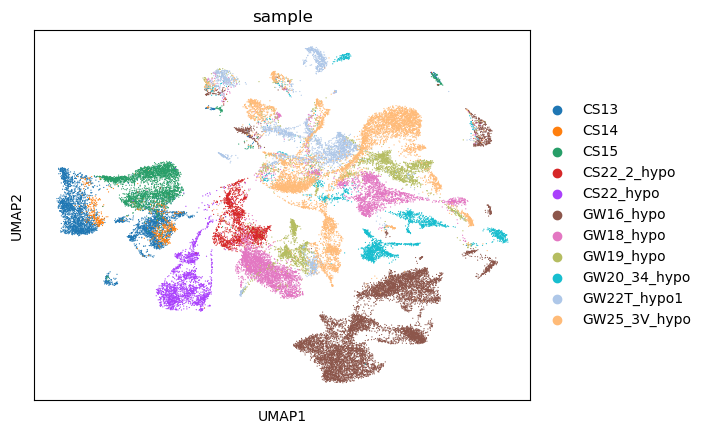

In [21]:
sc.pl.umap(adata_batches, color="Cell_types")
sc.pl.umap(adata_batches, color="sample")